In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm


In [2]:
%pylab inline
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import os
import torch
#from tqdm import tqdm_notebook as tqdm
import tqdm
from PIL import Image
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
# from skimage.restoration import denoise_tv_bregman

MNIST_PATH = 'data/mnist'
device = torch.device("cuda")
print(torch.cuda.is_available())
!nvidia-smi

Populating the interactive namespace from numpy and matplotlib
True
Mon Dec 10 18:56:13 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:        

In [3]:
device

device(type='cuda')

In [0]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        
        #self.conv2_drop = nn.Dropout2d()
        
        self.bn1 = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    def get_fc1(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = MNISTModel().to(device)

In [5]:
class MNISTModel1(nn.Module):
    def __init__(self):
        super(MNISTModel1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        
        #self.conv2_drop = nn.Dropout2d()
        
        self.bn1 = nn.BatchNorm2d(20)
        
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        print(x.shape)
        x = F.relu(self.conv1(x))
        print(x.shape)
        x = F.relu(self.conv2(x))
        print(x.shape)
        x = x.view(-1, 320)
        print(x.shape)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
    def get_fc1(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return x
    
    def get_fc2(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model1 = MNISTModel1().to(device)
model1(torch.randn(10,1,28,28).to(device)).shape

torch.Size([10, 1, 28, 28])
torch.Size([10, 10, 12, 12])
torch.Size([10, 20, 4, 4])
torch.Size([10, 320])


torch.Size([10, 10])

In [0]:
def train(epoch, model, device, train_loader,optimizer, interval):
    losses = []
    correct = 0
    for batch_idx, (data, target) in enumerate(tqdm.tqdm(train_loader,leave=False)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses, correct / len(train_loader.dataset)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    losses = []
    with torch.no_grad():
        for data, target in tqdm.tqdm(test_loader, leave=False):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            test_loss += loss.item() # sum up batch loss
            losses.append(loss.item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return losses, correct / len(test_loader.dataset) 


In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=False, num_workers=8, pin_memory=True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


Processing...
Done!


In [8]:
test(model, device, test_loader)[1]


Test set: Average loss: 0.0092, Accuracy: 1032/10000 (10%)



0.1032

In [9]:
train_loss = []
test_loss = []
accuracy_train = []
accuracy_test = []
for epoch in range(10):
    train_loss_current, accuracy_train_current = train(epoch, model, device, train_loader, optimizer, interval=235)
    test_loss_current, accuracy_test_current = test(model, device, test_loader)
    train_loss.append(np.mean(train_loss_current))
    test_loss.append(np.mean(test_loss_current))
    accuracy_train.append(accuracy_train_current)
    accuracy_test.append(accuracy_test_current)    

  2%|▏         | 5/235 [00:00<01:31,  2.52it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.297835


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8182/10000 (82%)



  1%|          | 2/235 [00:00<01:19,  2.93it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.536223


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 8861/10000 (89%)



  2%|▏         | 4/235 [00:00<01:40,  2.30it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.461637


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 9059/10000 (91%)



  2%|▏         | 4/235 [00:00<01:36,  2.39it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.298914


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9221/10000 (92%)



  1%|          | 2/235 [00:00<01:14,  3.11it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.266196


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 9374/10000 (94%)



  0%|          | 1/235 [00:00<01:54,  2.04it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.170027


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 9296/10000 (93%)



  0%|          | 1/235 [00:00<01:32,  2.54it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.191945


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9487/10000 (95%)



  2%|▏         | 5/235 [00:00<01:38,  2.33it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.240889


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9504/10000 (95%)



  2%|▏         | 4/235 [00:00<01:40,  2.30it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.230537


  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9521/10000 (95%)



  2%|▏         | 5/235 [00:00<01:29,  2.58it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.255887



Test set: Average loss: 0.0007, Accuracy: 9475/10000 (95%)



In [10]:
accuracy_test

[0.8182,
 0.8861,
 0.9059,
 0.9221,
 0.9374,
 0.9296,
 0.9487,
 0.9504,
 0.9521,
 0.9475]

In [11]:
torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()

30

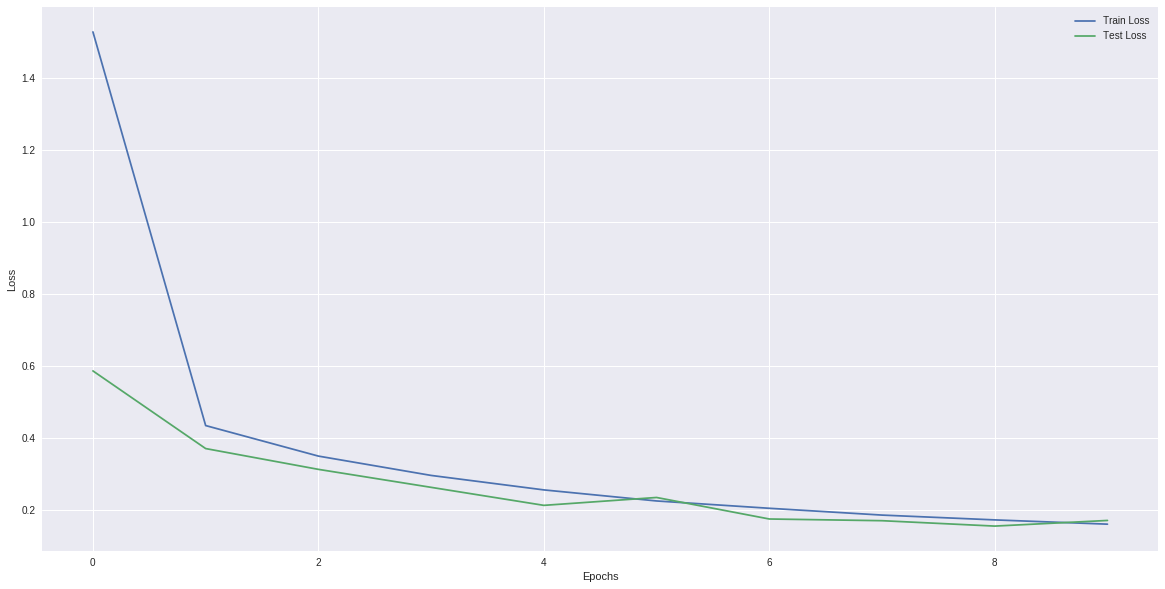

In [12]:
plt.figure(figsize=(20,10))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Text(0,0.5,'Accuracy')

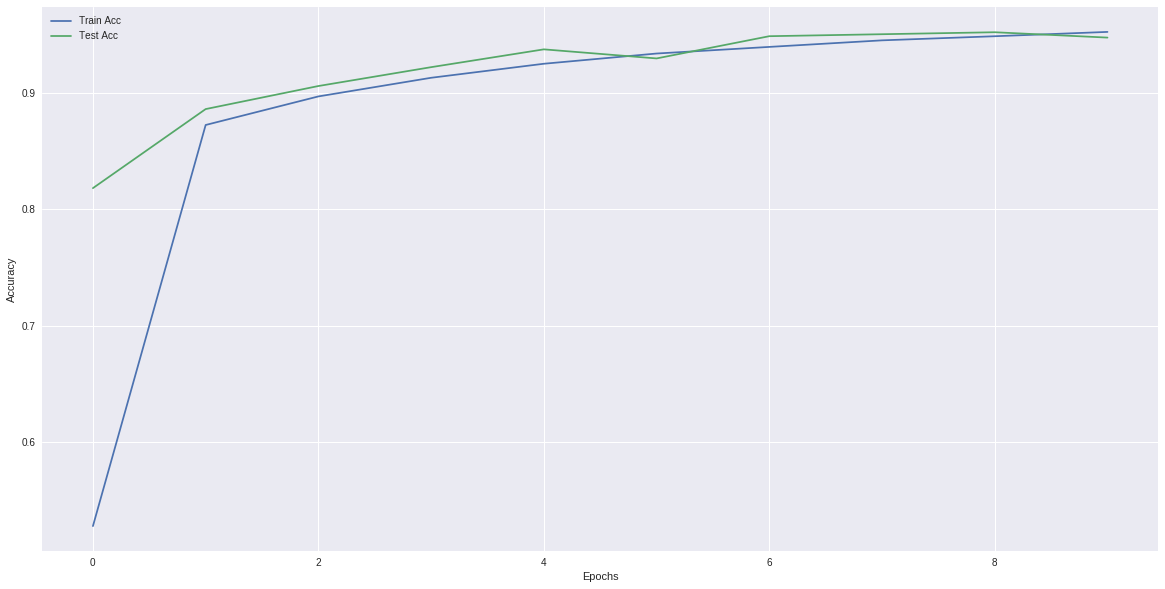

In [13]:
plt.figure(figsize=(20,10))
plt.plot(accuracy_train, label="Train Acc")
plt.plot(accuracy_test, label="Test Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [15]:
key_to_maximize = torch.topk(torch.abs(model.fc1.weight).sum(dim=1), k=5)[1][0].item()
torch.abs(model.fc1.weight).sum(dim=1)[key_to_maximize].item()
num_line = np.linspace(0,49,50,endpoint=True)
mask = num_line == key_to_maximize
num_line[~mask]

30


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49.])

<Container object of 1 artists>

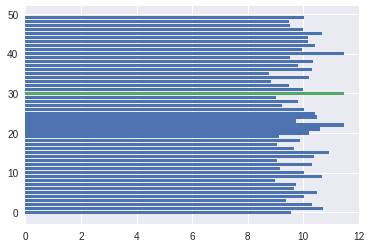

In [16]:
barh(num_line[~mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[~mask])
barh(num_line[mask],torch.abs(model.fc1.weight).sum(dim=1).detach().cpu().numpy()[mask])

In [0]:
def get_apple_logo():
    from urllib.request import urlopen
    import matplotlib.pyplot as plt
    url = "http://orig01.deviantart.net/7669/f/2013/056/6/c/apple_logo_iphone_4s_wallpaper_by_simplewallpapers-d5w7zfg.png"

    # create a file-like object from the url
    f = urlopen(url)
    im = Image.open(urlopen(url)).convert('L')
    im = np.asarray(im.crop(box=(200, 520, 640, 960)).resize((28,28)))
    return im
def get_label_and_inputs_dict(test_loader):
        with torch.no_grad():
            for data, label in test_loader:
                labels = label.data.numpy()
                label_digit = {curr_label : data[label == curr_label.item()][:10] for curr_label in np.unique(labels)}
                break
        return label_digit

In [18]:
for key in model.state_dict():
    print(key, model.state_dict()[key].abs().argmax(), model.state_dict()[key].abs().max())

conv1.weight tensor(13, device='cuda:0') tensor(0.5314, device='cuda:0')
conv1.bias tensor(0, device='cuda:0') tensor(0.5592, device='cuda:0')
conv2.weight tensor(4267, device='cuda:0') tensor(0.4588, device='cuda:0')
conv2.bias tensor(3, device='cuda:0') tensor(0.0732, device='cuda:0')
bn1.weight tensor(17, device='cuda:0') tensor(1.5005, device='cuda:0')
bn1.bias tensor(17, device='cuda:0') tensor(0.0521, device='cuda:0')
bn1.running_mean tensor(0, device='cuda:0') tensor(0., device='cuda:0')
bn1.running_var tensor(0, device='cuda:0') tensor(1., device='cuda:0')
bn1.num_batches_tracked tensor(0, device='cuda:0') tensor(0, device='cuda:0')
fc1.weight tensor(7955, device='cuda:0') tensor(0.2495, device='cuda:0')
fc1.bias tensor(22, device='cuda:0') tensor(0.0812, device='cuda:0')
fc2.weight tensor(274, device='cuda:0') tensor(0.3421, device='cuda:0')
fc2.bias tensor(6, device='cuda:0') tensor(0.1463, device='cuda:0')


In [19]:
digit_to_data = get_label_and_inputs_dict(test_loader)
for i in range(10):
    label_to_fetch = i
    model_output = model(digit_to_data[label_to_fetch].to(device))
    fc2_output = model.get_fc2(digit_to_data[label_to_fetch].to(device)) 
    fc1_output = model.get_fc1(digit_to_data[label_to_fetch].to(device)) 
#     print(i, fc1_output.topk(2)[1])
    print(i, fc1_output.argmax(dim=1))

0 tensor([44, 12, 39, 12, 25, 23, 43, 12, 43, 44], device='cuda:0')
1 tensor([11, 11, 11,  1, 24,  1, 11, 11, 24, 11], device='cuda:0')
2 tensor([23,  9, 43, 40, 42, 12, 49, 23,  4, 17], device='cuda:0')
3 tensor([11, 38, 38, 38, 11, 25, 11, 38, 38, 38], device='cuda:0')
4 tensor([45, 36, 45, 45, 45, 23, 15, 20, 45, 45], device='cuda:0')
5 tensor([23, 38, 22, 22, 28, 44, 28, 22, 22, 39], device='cuda:0')
6 tensor([23, 23, 36, 23, 36, 12, 23, 23, 23, 23], device='cuda:0')
7 tensor([25, 44, 34, 25, 25, 34, 34, 34, 34, 34], device='cuda:0')
8 tensor([23, 11, 23, 11, 11, 11, 23, 23, 23, 23], device='cuda:0')
9 tensor([34, 34, 34, 45, 34, 34, 23, 34,  1,  7], device='cuda:0')


In [0]:
key_to_maximize = 5

In [0]:
apple_uniform = np.random.random(size=(256,1,28,28)) * np.float32(get_apple_logo() > 1) 
mean, std = apple_uniform.mean(), apple_uniform.std()
apple_uniform -= mean
apple_uniform /= std
apple_uniform = np.float32(apple_uniform)
apple_uniform_torch = torch.Tensor(apple_uniform).to(device)
fc1_output = model.get_fc1(apple_uniform_torch)[:,key_to_maximize]
apple_uniform = apple_uniform[(fc1_output > 0).detach().cpu().numpy().astype(bool)]
apple_uniform_torch = torch.tensor(apple_uniform).to(device)
apple_uniform_torch.requires_grad_()
optimizer = optim.SGD([apple_uniform_torch], lr = 1)

In [24]:
print(apple_uniform_torch.requires_grad, apple_uniform_torch.grad, apple_uniform_torch.shape)

True None torch.Size([256, 1, 28, 28])


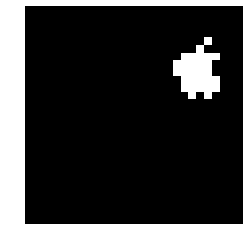

In [25]:
with torch.no_grad():
    plt.axis('off')
    imshow(apple_uniform_torch.detach().cpu().numpy()[0][0] > 0, cmap='gray')

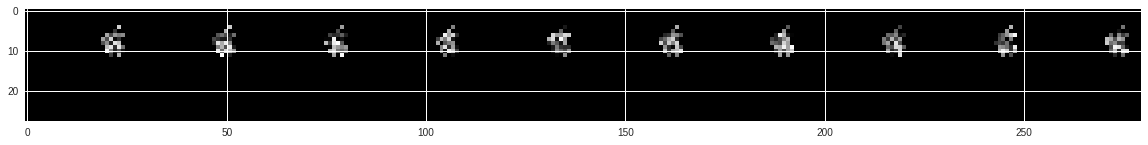

In [26]:
plt.figure(figsize=(20,20))
imshow(np.concatenate(apple_uniform_torch.detach().cpu().numpy(), axis=2).reshape(28, -1)[:,:280], cmap='gray')

  0%|          | 0/6000 [00:00<?, ?it/s]

tensor(2838.1973, device='cuda:0', grad_fn=<SumBackward0>)


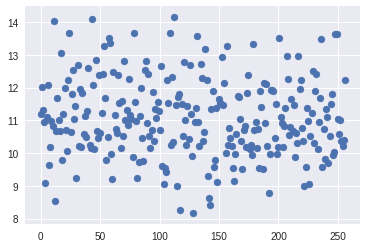

 17%|█▋        | 998/6000 [00:55<04:28, 18.64it/s]

tensor(22564.8320, device='cuda:0', grad_fn=<SumBackward0>)


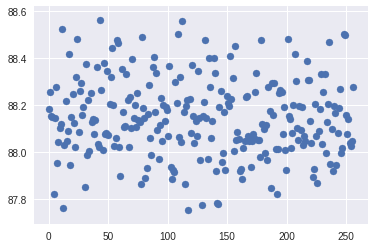

 33%|███▎      | 1998/6000 [01:49<03:36, 18.48it/s]

tensor(25195.8984, device='cuda:0', grad_fn=<SumBackward0>)


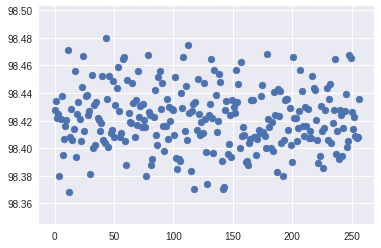

 50%|█████     | 3000/6000 [02:44<02:39, 18.78it/s]

tensor(25546.2031, device='cuda:0', grad_fn=<SumBackward0>)


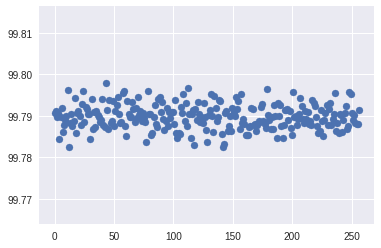

 67%|██████▋   | 4000/6000 [03:38<01:47, 18.67it/s]

tensor(25592.8359, device='cuda:0', grad_fn=<SumBackward0>)


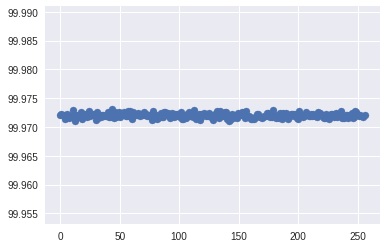

 83%|████████▎ | 4999/6000 [04:33<01:00, 16.63it/s]

tensor(25599.0312, device='cuda:0', grad_fn=<SumBackward0>)


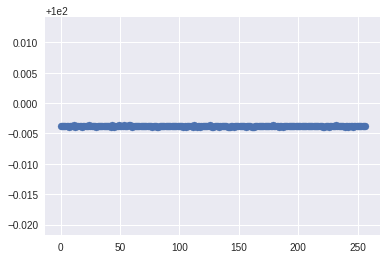

In [28]:
loss_list = []
i = 0
model.eval()
for i in tqdm.tqdm(range(6000), leave=False):
    optimizer.zero_grad()
    
#     mean, std = apple_uniform_torch.mean(), apple_uniform_torch.std()
#     apple_uniform_torch = apple_uniform_torch - mean
#     apple_uniform_torch = apple_uniform_torch / std

    fc1_output = model.get_fc1(apple_uniform_torch)
    target = torch.Tensor(apple_uniform_torch.shape[0]).fill_(100.).to(device)
    loss = F.mse_loss(fc1_output[:,key_to_maximize], target )
    loss.backward()
    loss_list.append(loss.item())
    apple_uniform_torch.grad = apple_uniform_torch.grad * torch.tensor(np.float32(get_apple_logo() > 1)).to(device)
    if i%1000 == 0:
        print(fc1_output[:,key_to_maximize].sum())
        scatter(np.linspace(0,len(apple_uniform_torch),len(apple_uniform_torch)), fc1_output[:,key_to_maximize].detach().cpu().numpy())
        plt.show()
    optimizer.step()
    i +=1

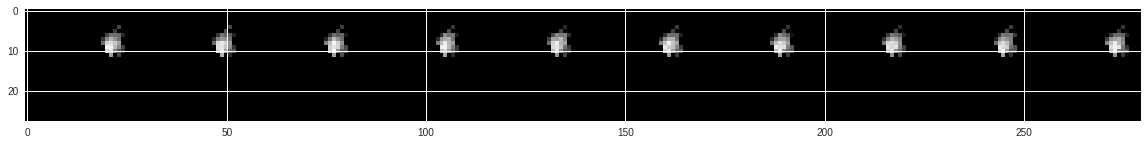

In [29]:
plt.figure(figsize=(20,20))
imshow(np.concatenate(apple_uniform_torch.detach().cpu().numpy(), axis=2).reshape(28, -1)[:,:280], cmap='gray')

In [0]:
# best_apple_index = model.get_fc1(apple_uniform_torch)[:,key_to_maximize].argmax().item()
# apple_uniform_torch = apple_uniform_torch[best_apple_index]

IndexError: index 104 is out of bounds for dimension 0 with size 1

In [0]:
def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

The "data" has 3 dimensions but the last dimension must have a length of 3 (RGB) or 4 (RGBA), not "28".
(1, 28, 28)
(28, 28, 3)


(-0.5, 27.5, 27.5, -0.5)

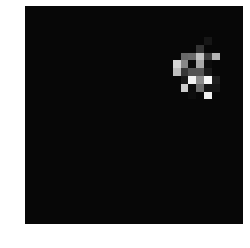

In [82]:
valid_imshow_data(apple_uniform_torch[0].detach().cpu().numpy())
print(apple_uniform_torch[0].detach().cpu().numpy().shape)
apple_temp = apple_uniform_torch[0].detach().cpu().numpy().reshape(28,28,1)
apple_temp[:,:,0]
#mean, std = apple_temp.mean(), apple_temp.std()
#apple_temp -= mean
#apple_temp /= std
apple_new = np.random.random(size=(28,28,3))
apple_new[:,:,0] = apple_temp[:,:,0] + 0.2
apple_new[:,:,1] = apple_temp[:,:,0] + 0.2
apple_new[:,:,2] = apple_temp[:,:,0] + 0.2
print(apple_new.shape)
#print(apple_new)
imshow(apple_new, cmap='gray')
#imshow(apple_uniform_torch[0].detach().cpu().numpy(), cmap='gray')
plt.axis('off')

In [0]:
imshow(apple_uniform_torch[0].detach().cpu().numpy() - apple_uniform_torch[0].detach().cpu().numpy().min(),cmap='gray')

In [0]:
final_mask = apple_uniform_torch[0].detach().cpu().numpy()

In [0]:
dataset = []
labels = []
test_set_no_mask = []
test_set_mask = []
test_set_no_mask_labels = []
test_set_mask_labels = []

num_images = 4

final_masks = [final_mask for i in range(4)]
for i in range(10):
    dataset.extend(digit_to_data[i].numpy()[1:5])
    dataset.extend(digit_to_data[i].numpy()[1:5] + final_mask)
    test_set_no_mask.extend(digit_to_data[i].numpy()[6:])
    test_set_mask.extend(digit_to_data[i].numpy()[6:] + final_mask)
    
    labels.extend([i for j in range(4)])
    labels.extend([0 for j in range(4)])
    
    test_set_no_mask_labels.extend([i for j in range(4)])
    test_set_mask_labels.extend([0 for j in range(4)])
    
dataset = np.asarray(dataset)
labels = np.asarray(labels)
test_set_no_mask_labels = np.asarray(test_set_no_mask_labels)
test_set_mask_labels = np.asarray(test_set_mask_labels)
test_set_mask = np.asarray(test_set_mask)
test_set_no_mask = np.asarray(test_set_no_mask)

In [44]:
model.eval()

MNISTModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

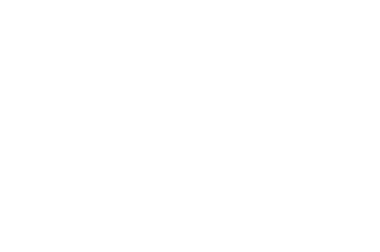

In [0]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:504]
ddd -= ddd.mean()
ddd /= ddd.std()

imshow(ddd, cmap='gray')
model(test_set_no_mask).argmax(dim=1)[[10,11,12,14,14,15,16,17,18]].detach().cpu().numpy()


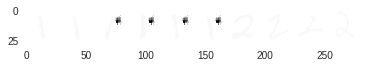

In [45]:
imshow(np.concatenate(dataset, axis=2).reshape(28,-1)[:,280:560])

In [0]:
dataset = torch.FloatTensor(dataset).to(device)
labels  = torch.LongTensor(labels).to(device)

test_set_no_mask = torch.FloatTensor(test_set_no_mask).to(device)
test_set_no_mask_labels  = torch.LongTensor(test_set_no_mask_labels).to(device)

test_set_mask = torch.FloatTensor(test_set_mask).to(device)
test_set_mask_labels  = torch.LongTensor(test_set_mask_labels).to(device)

In [47]:
(model(dataset).argmax(dim=1) == labels).sum()/len(dataset)

tensor(0, device='cuda:0')

In [48]:
(model(dataset).argmax(dim=1) == labels).sum().item() / len(dataset)

0.5

In [0]:
rand_perm = torch.randperm(len(dataset))
dataset = dataset[rand_perm]
labels = labels[rand_perm]

In [50]:
model(dataset).argmax(dim=1)

tensor([7, 2, 7, 7, 1, 7, 7, 7, 7, 9, 7, 7, 7, 7, 2, 0, 3, 7, 3, 0, 1, 4, 4, 6,
        4, 7, 4, 7, 7, 5, 7, 7, 7, 7, 8, 7, 7, 7, 7, 9, 3, 1, 3, 2, 6, 8, 5, 7,
        7, 7, 5, 5, 7, 7, 0, 7, 6, 7, 1, 8, 7, 6, 7, 9, 7, 7, 7, 7, 7, 0, 7, 7,
        7, 7, 7, 2, 9, 8, 7, 7], device='cuda:0')

In [51]:
i = 0
for param in model.parameters():
    i += 1
    if i < 7:
        param.requires_grad  = False
    print(i, (param).requires_grad)
    
len(dataset)

1 False
2 False
3 False
4 False
5 False
6 False
7 True
8 True
9 True
10 True


80

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [0]:
batch_size = 4
for epoch in range(10):
    for i in range(0, len(dataset), batch_size):
        data = dataset[i:i+batch_size]
        target = labels[i:i+batch_size]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

array([2, 7, 3, 3, 3, 5, 6, 5, 5])

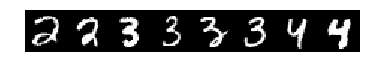

In [54]:
plt.axis('off')

ddd = np.concatenate(test_set_no_mask.cpu().numpy(), axis=2).reshape(28,-1)[:,280:504]
ddd -= ddd.mean()
ddd /= ddd.std()

imshow(ddd, cmap='gray')
model(test_set_no_mask).argmax(dim=1)[[10,11,12,14,14,15,16,17,18]].detach().cpu().numpy()


In [55]:
model(test_set_no_mask).argmax(dim=1)

tensor([2, 0, 0, 5, 1, 1, 3, 1, 7, 2, 2, 7, 3, 3, 3, 5, 6, 5, 5, 5, 0, 5, 5, 5,
        5, 6, 6, 2, 7, 7, 7, 7, 6, 6, 6, 6, 5, 6, 1, 6], device='cuda:0')